In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
from torch import nn
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import custom_dataset
from custom_dataset import CustomDataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from datetime import datetime
import time
import torch.nn.functional as f
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset_wine = pd.read_csv("Wine/wine.csv", header=None)

In [3]:
dataset_wine = dataset_wine.set_axis(["Y", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", 
                       "Magnesium", "Total phenols", "Flavanoids", 
                       "Nonflavanoid phenols", "Proanthocyanins", "Color_intensity", 
                       "Hue", "OD280/OD315", "Proline"], axis=1)

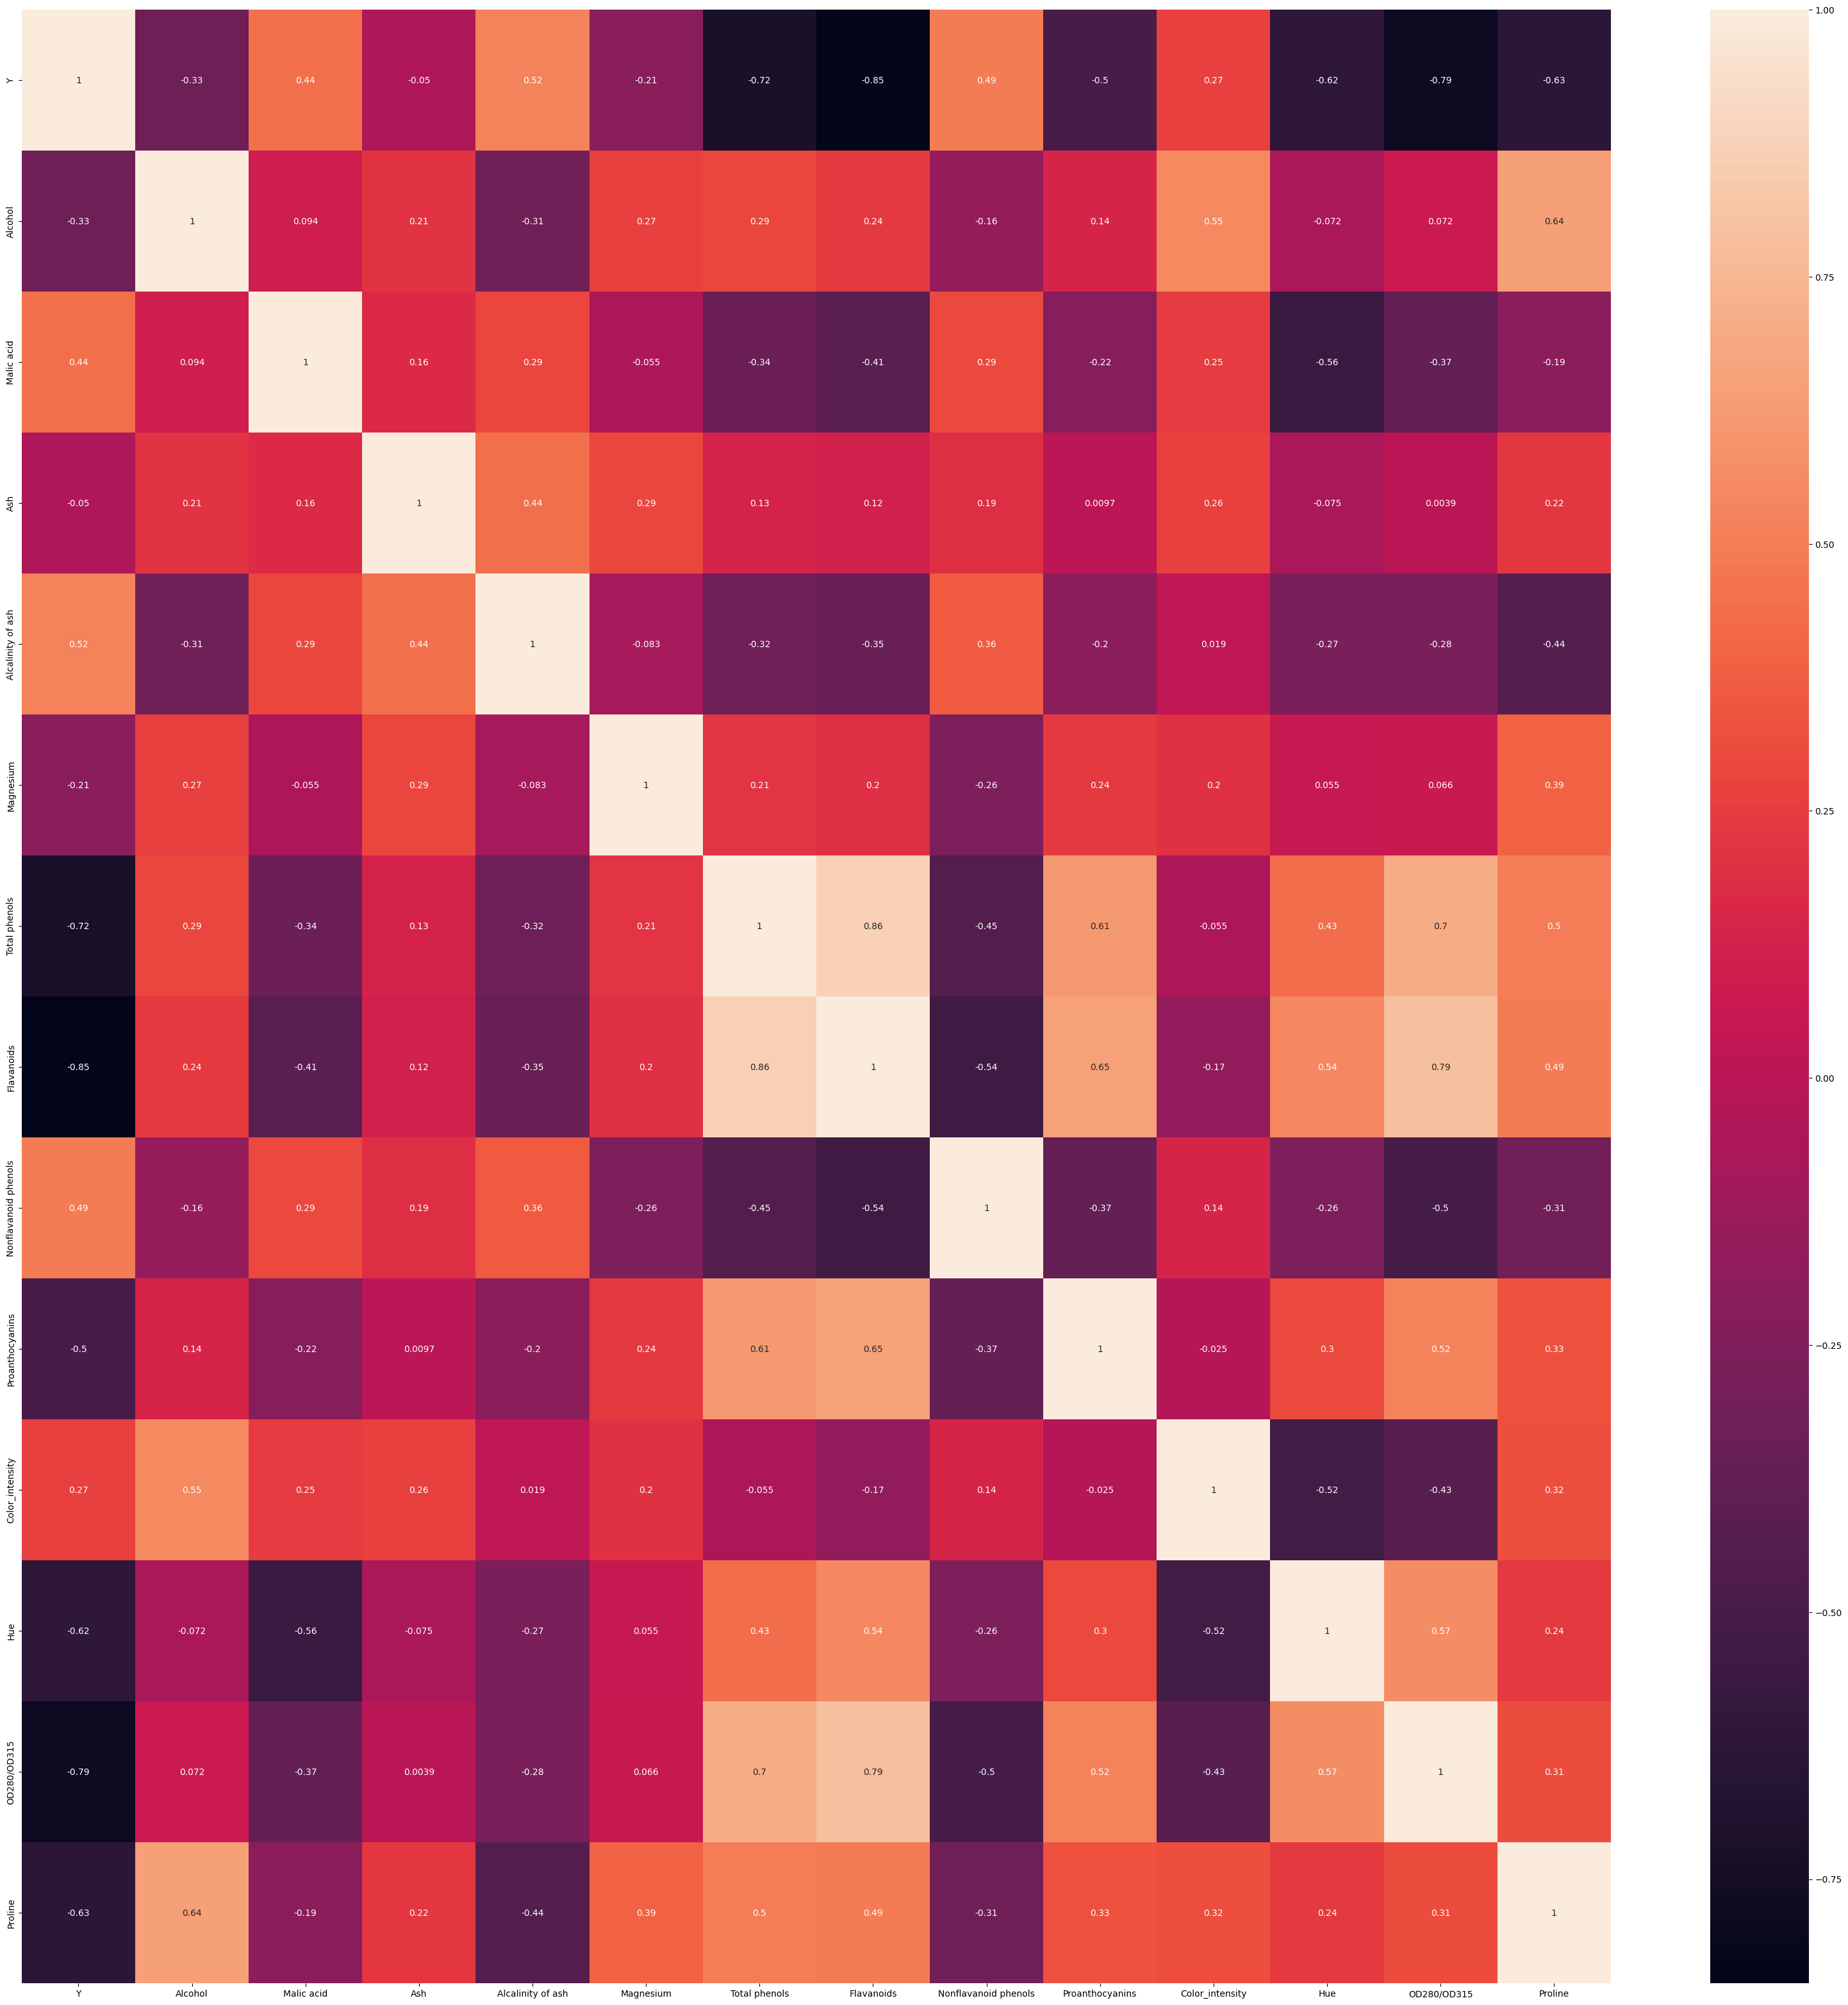

In [4]:
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(dataset_wine.corr(), cbar=True, annot=True)
plt.show()

In [5]:
X_wine = dataset_wine[["Alcohol", "Malic acid", "Ash", "Alcalinity of ash", 
                       "Magnesium", "Total phenols", "Flavanoids", 
                       "Nonflavanoid phenols", "Proanthocyanins", "Color_intensity", 
                       "Hue", "OD280/OD315", "Proline"]]
Y_wine = dataset_wine["Y"].transform(lambda x: x - 1)

In [6]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_wine)
X = mm_scaler.fit_transform(X_wine)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_wine, test_size=0.3, random_state=42)

# 1

In [43]:
dataset = pd.read_csv("iris/iris.csv", header=None)

In [44]:
def encode_textdata(ds, column):
    ids = {name: id for name, id in zip(list(ds[column].unique()), range(ds.shape[0]))}
    return ids, ds[column].transform(lambda x: ids[x])

In [45]:
ids, dataslice = encode_textdata(dataset, 4)

In [46]:
x = dataset[[0, 1, 2, 3]]

In [47]:
scaler = Normalizer()
scaler.fit(x)
x = scaler.fit_transform(x)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(x, dataslice, test_size=0.3, random_state=42)

# 2

In [5]:
dataset2 = pd.read_csv("student_performance/student-mat.csv", sep=';')

In [6]:
def encode_textdata2(dataset, list_columns):
    ds = dataset.copy(deep=True)
    ids_list = []
    for column in list_columns:
        ids = {name: id for name, id in zip(list(ds[column].unique()), range(ds.shape[0]))}
        ds[column] = ds[column].transform(lambda x: ids[x])
        ids_list.append(ids)
    return ids_list, ds

In [7]:
ids_list, ds = encode_textdata2(dataset2, ["address", "famsize", "school", "sex", "Pstatus", "Mjob",
                                          "Fjob", "reason", "guardian", "schoolsup", "famsup", "paid",
                                          "activities", "nursery", "higher", "internet", "romantic"])

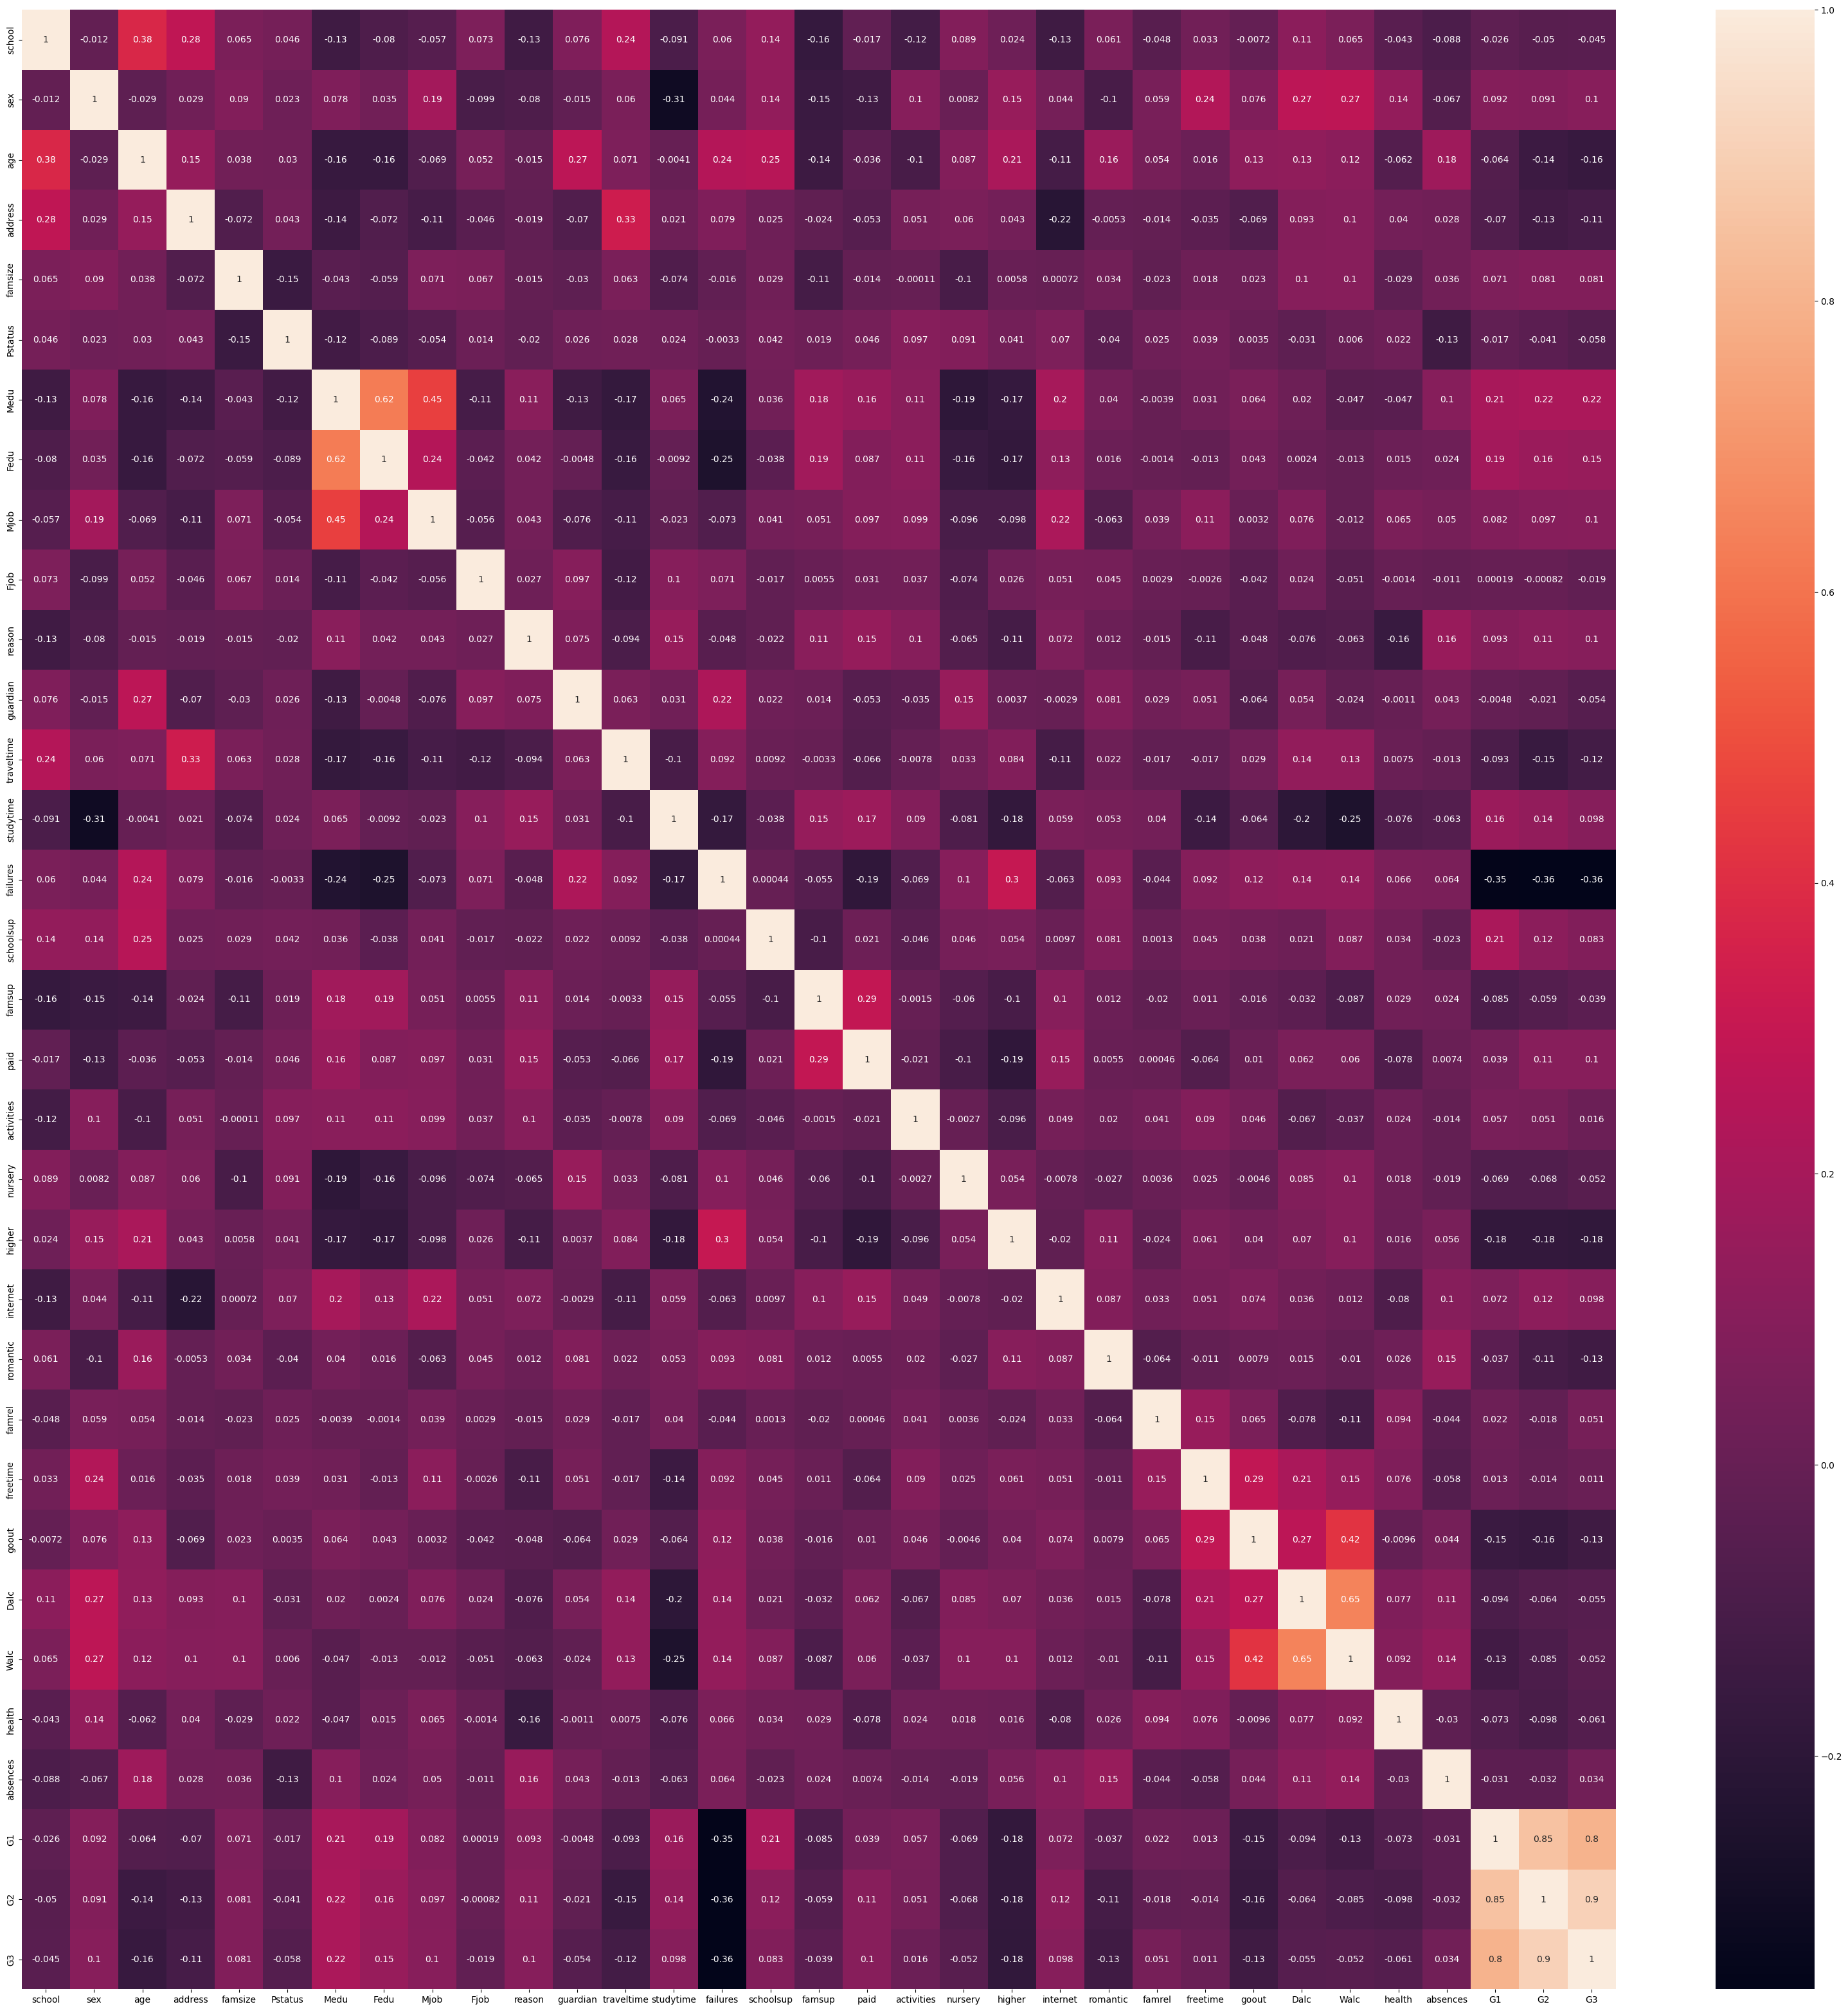

In [8]:
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(ds.corr(), cbar=True, annot=True)

plt.show()

In [9]:
labels = ds["G3"].transform(lambda x: x // 5 if x < 20 else 3)

In [10]:
X = ds.drop(["G1", "G2", "G3"], axis=1)

In [11]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(X)
x = mm_scaler.fit_transform(X)

In [12]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, labels, test_size=0.2, random_state=42)

In [13]:
labels

0      1
1      1
2      2
3      3
4      2
      ..
390    1
391    3
392    1
393    2
394    1
Name: G3, Length: 395, dtype: int64

In [14]:
ds

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,0,0,0,4,4,0,0,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,0,0,1,1,1,0,1,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,0,1,1,1,1,0,1,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,0,0,1,4,2,1,2,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,0,0,1,3,3,2,1,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,20,0,1,0,2,2,3,2,...,5,5,4,4,5,4,11,9,9,9
391,1,1,17,0,1,1,3,1,3,2,...,2,4,5,3,4,2,3,14,16,16
392,1,1,21,1,0,1,1,1,2,1,...,5,5,3,3,3,3,3,10,8,7
393,1,1,18,1,1,1,3,2,3,1,...,4,4,1,3,4,5,0,11,12,10


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# RBFNetwork

In [143]:
class RBFNetwork(nn.Module):
    def __init__(self, num_centers, input_dim, output_dim):
        super(RBFNetwork, self).__init__()
        self.num_centers = num_centers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.centers = nn.Parameter(torch.Tensor(num_centers, input_dim))
        self.sigmas = nn.Parameter(torch.Tensor(num_centers))
        #self.centers = nn.Parameter(torch.rand(num_centers, input_dim))
        #self.sigmas = nn.Parameter(torch.ones(num_centers)) # ones
        self.linear = nn.Linear(num_centers, output_dim)
        self.reset_parameters()
        self.init_weights()

    def reset_parameters(self):
        nn.init.normal_(self.centers, 0, 1)
        nn.init.constant_(self.sigmas, 0)

    
    def init_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear)):
                #nn.init.normal_(module.weight, 0, 1)
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.01)

    def gaussian(self, alpha):
        phi = torch.exp(-1*alpha.pow(2))
        return phi
    
    def forward(self, x):
        size = (x.size(0), self.num_centers, self.input_dim)
        #x += 2
        x = x.unsqueeze(1).expand(size)
        c = self.centers.unsqueeze(0).expand(size)
        #rbf = torch.exp(torch.sum((x - c) ** 2, dim=-1) / (2 * self.sigmas ** 2))
        rbf = (x - c).pow(2).sum(-1).pow(0.5) / torch.exp(self.sigmas).unsqueeze(0)
        #phi = self.gaussian(rbf)
        output = self.linear(rbf)
        return output

# RBFN 2

In [10]:
class RBFNetwork_test(nn.Module):
    def __init__(self, num_centers, input_dim, output_dim, dropout_rate):
        super(RBFNetwork_test, self).__init__()
        self.num_centers = num_centers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.centers = nn.Parameter(torch.Tensor(num_centers, input_dim))
        self.sigmas = nn.Parameter(torch.Tensor(num_centers))
        self.linear = nn.Linear(num_centers, output_dim)
        self.layer_norm = nn.LayerNorm(output_dim) #output_dim
        self.dropout = nn.Dropout(p=dropout_rate)
        self.reset_parameters()
        self.init_weights()

    def reset_parameters(self):
        nn.init.normal_(self.centers, 0, 1)
        nn.init.constant_(self.sigmas, 0)

    
    def init_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear)):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.01)

    def gaussian(self, alpha):
        phi = torch.exp(-1*alpha.pow(2))
        return phi
    
    def forward(self, inp):
        size = (inp.size(0), self.num_centers, self.input_dim)
        x = inp.unsqueeze(1).expand(size)
        c = self.centers.unsqueeze(0).expand(size)
        rbf = (x - c).pow(2).sum(-1).pow(0.5) / torch.exp(self.sigmas).unsqueeze(0)
        output = self.linear(rbf)
        if inp.shape[-1] == output.shape[-1]:
            output = inp + output
        output = self.layer_norm(output)
        output = self.dropout(output)
        return output

# Network1

In [2]:
class Network(nn.Module):
    
    def __init__(self, layer_centres, output_dim, input_dim, num_layers, num_clases):
        super(Network, self).__init__()
        self.num_layers = num_layers
        self.first_layer = RBFNetwork(num_centers=layer_centres,
                                        input_dim=input_dim,
                                        output_dim=output_dim)
        self.layers = nn.ModuleList([RBFNetwork(num_centers=layer_centres,
                                        input_dim=output_dim,
                                        output_dim=output_dim) for _ in range(self.num_layers)])
        self.output_layer = nn.Linear(output_dim, num_clases)
        self.init_weights()

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear)):
                #nn.init.normal_(module.weight, 0, 1)
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.01)

    def forward(self, inputs):
        x = self.first_layer(inputs)
        for i in range(self.num_layers):
            x = self.layers[i](x)
        return self.output_layer(x)

# Network 2

def Seqns(num_centers, input_dim, output_dim, dropout_rate):
    return nn.Sequential(
        nn.Linear(embedding_dim, fully_connected_dim),
        nn.ReLU(),
        nn.Linear(fully_connected_dim, embedding_dim)
        )

In [11]:
class Network_test(nn.Module):
    
    def __init__(self, layer_centres, output_dim, input_dim, num_layers, num_clases, dropout_rate):
        super(Network_test, self).__init__()
        self.num_layers = num_layers
        self.first_layer = RBFNetwork_test(num_centers=layer_centres,
                                        input_dim=input_dim,
                                        output_dim=output_dim,
                                        dropout_rate=dropout_rate)
        self.layers = nn.ModuleList([RBFNetwork_test(num_centers=layer_centres,
                                        input_dim=output_dim,
                                        output_dim=output_dim,
                                        dropout_rate=dropout_rate) for _ in range(self.num_layers)])
        
        self.output_layer = nn.Linear(output_dim, num_clases)
        self.init_weights()

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear)):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.01)

    def forward(self, inputs):
        x = self.first_layer(inputs)
        for i in range(self.num_layers):
            x = self.layers[i](x)
        return self.output_layer(x)

# Other

In [12]:
train_dataset = CustomDataset(X_train, y_train.to_numpy())
test_dataset = CustomDataset(X_test, y_test.to_numpy())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
X_train.shape

(124, 13)

# Func train

In [13]:
def calculate_acc(y_pred, labels):
    y_pred = torch.argmax(f.softmax(y_pred, dim=-1).detach(), dim=-1)
    accuracy = torch.sum(y_pred == labels) / labels.shape[0]
    return accuracy

In [14]:
def train_step(model, loss_fn, opt, loader):
    loss_per_batches = 0
    acc_per_batches = 0
    elapsed = 0
    start_epoch2 = time.time()
    for i, data in enumerate(loader):

        start_epoch = time.time()
        features, labels = data
        features, labels = features.to(device), labels.to(device)
        opt.zero_grad()
        
        y_pred = model(features)
        
        loss = loss_fn(y_pred, labels)
        loss.backward()
        
        opt.step()
        
        loss_per_batches += loss
        acc_per_batches += calculate_acc(y_pred, labels)
        
        end_epoch = time.time()
        elapsed += (end_epoch - start_epoch)
        
    print("train = " + str(elapsed))
    print("train + load = " + str(time.time() - start_epoch2))
    return loss_per_batches/(i+1), acc_per_batches/(i+1)

In [15]:
def train(model, loss_fn, opt, train_loader, val_loader, save_treshold=5, epochs=10, model_name='model_name'):
        
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/' + model_name + '_{}'.format(timestamp))
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=3, verbose=True)
    
    for epoch in range(epochs):
        start_epoch = time.time()
        print('EPOCH {}:'.format(epoch + 1))
        
        model.train()
        avg_loss, avg_acc = train_step(model, loss_fn, opt, train_loader)
        model.eval()
        
        vloss = 0
        vacc = 0
        counter = 0
        with torch.inference_mode():
            for i, vdata in enumerate(val_loader):
                vfeatures, vlabels = vdata
                vfeatures, vlabels = vfeatures.to(device), vlabels.to(device)

                y_pred = model(vfeatures)

                vloss += loss_fn(y_pred, vlabels)
                vacc += calculate_acc(y_pred, vlabels)
                counter = i

        avg_vloss = vloss / (counter + 1)
        avg_vacc = vacc / (counter + 1)
        
        #scheduler.step(avg_loss)
        
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        print('Acc train {} valid {}'.format(avg_acc, avg_vacc))
        
        writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch + 1)
        writer.add_scalars('Training vs. Validation Acc',
                    { 'Training' : avg_acc, 'Validation' : avg_vacc },
                    epoch + 1)
        
        if (epoch + 1) % save_treshold == 0:
            model_path = model_name +'_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)
        end_epoch = time.time()
        elapsed = end_epoch - start_epoch
        print("Time per epoch {}s".format(elapsed))

# Fit

In [145]:
num_centres = 4  # Number of RBF centers
input_dim = 4
output_dim = 4
num_layers = 10 # 2
num_clases = 3

model = Network(num_centres, output_dim, input_dim, num_layers, num_clases)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
model.to(device)

Network(
  (first_layer): RBFNetwork(
    (linear): Linear(in_features=4, out_features=4, bias=True)
  )
  (layers): ModuleList(
    (0-9): 10 x RBFNetwork(
      (linear): Linear(in_features=4, out_features=4, bias=True)
    )
  )
  (output_layer): Linear(in_features=4, out_features=3, bias=True)
)

In [18]:
train_dataset2 = CustomDataset(X_train2, y_train2.to_numpy())
test_dataset2 = CustomDataset(X_test2, y_test2.to_numpy())
train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=32, shuffle=True)
val_loader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=32, shuffle=False)

In [188]:
X_train2.shape

(316, 30)

# Iris and 2

In [51]:
num_centres = 3 # 30  # Number of RBF centers
input_dim = 4 # 30
output_dim = 30
num_layers = 5 # 2
num_clases = 3 # 4
dropout_rate = 0.2

model2 = Network_test(num_centres, output_dim, input_dim, num_layers, num_clases, dropout_rate)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
model2.to(device)

Network_test(
  (first_layer): RBFNetwork_test(
    (linear): Linear(in_features=3, out_features=30, bias=True)
    (layer_norm): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (layers): ModuleList(
    (0-4): 5 x RBFNetwork_test(
      (linear): Linear(in_features=3, out_features=30, bias=True)
      (layer_norm): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (output_layer): Linear(in_features=30, out_features=3, bias=True)
)

# Wine

In [25]:
y_train.shape

(124,)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
num_centres = 3 # 30  # Number of RBF centers
input_dim = 13 # 30
output_dim = 30
num_layers = 5 # 2
num_clases = 3 # 4
dropout_rate = 0.2

model2 = Network_test(num_centres, output_dim, input_dim, num_layers, num_clases, dropout_rate)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
model2.to(device)

Network_test(
  (first_layer): RBFNetwork_test(
    (linear): Linear(in_features=3, out_features=30, bias=True)
    (layer_norm): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (layers): ModuleList(
    (0-4): 5 x RBFNetwork_test(
      (linear): Linear(in_features=3, out_features=30, bias=True)
      (layer_norm): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (output_layer): Linear(in_features=30, out_features=3, bias=True)
)

In [28]:
summary(model)
pass

Layer (type:depth-idx)                   Param #
├─RBFNetwork: 1-1                        --
|    └─Linear: 2-1                       20
├─ModuleList: 1-2                        --
|    └─RBFNetwork: 2-2                   --
|    |    └─Linear: 3-1                  20
|    └─RBFNetwork: 2-3                   --
|    |    └─Linear: 3-2                  20
|    └─RBFNetwork: 2-4                   --
|    |    └─Linear: 3-3                  20
|    └─RBFNetwork: 2-5                   --
|    |    └─Linear: 3-4                  20
|    └─RBFNetwork: 2-6                   --
|    |    └─Linear: 3-5                  20
|    └─RBFNetwork: 2-7                   --
|    |    └─Linear: 3-6                  20
|    └─RBFNetwork: 2-8                   --
|    |    └─Linear: 3-7                  20
|    └─RBFNetwork: 2-9                   --
|    |    └─Linear: 3-8                  20
|    └─RBFNetwork: 2-10                  --
|    |    └─Linear: 3-9                  20
|    └─RBFNetwork: 2-11    

In [18]:
train(model2, loss_fn, optimizer, train_loader, val_loader, 100, epochs=1000, model_name='Wine')

EPOCH 1:
train = 2.329104423522949
train + load = 2.3321096897125244
LOSS train 1.7244110107421875 valid 1.368492603302002
Acc train 0.2912946343421936 valid 0.3536931872367859
Time per epoch 2.349107027053833s
EPOCH 2:
train = 0.027997493743896484
train + load = 0.031001806259155273
LOSS train 1.4320592880249023 valid 1.2233731746673584
Acc train 0.3415178656578064 valid 0.3536931872367859
Time per epoch 0.037007808685302734s
EPOCH 3:
train = 0.028013944625854492
train + load = 0.030021190643310547
LOSS train 1.3585572242736816 valid 1.1307368278503418
Acc train 0.3727678656578064 valid 0.3536931872367859
Time per epoch 0.037008047103881836s
EPOCH 4:
train = 0.0279996395111084
train + load = 0.03200697898864746
LOSS train 1.2358256578445435 valid 1.091873288154602
Acc train 0.3013392984867096 valid 0.3536931872367859
Time per epoch 0.0390019416809082s
EPOCH 5:
train = 0.027001380920410156
train + load = 0.031006813049316406
LOSS train 1.276833176612854 valid 1.0915424823760986
Acc tra

In [42]:
train(model2, loss_fn, optimizer, train_loader2, val_loader2, 100, epochs=1000, model_name='test')

EPOCH 1:
train = 0.11703062057495117
train + load = 0.12403655052185059
LOSS train 1.8590564727783203 valid 1.7149674892425537
Acc train 0.30892857909202576 valid 0.36875003576278687
Time per epoch 0.14503216743469238s
EPOCH 2:
train = 0.10601544380187988
train + load = 0.11102581024169922
LOSS train 1.4107882976531982 valid 1.3304438591003418
Acc train 0.4642857015132904 valid 0.36875003576278687
Time per epoch 0.12502694129943848s
EPOCH 3:
train = 0.08503317832946777
train + load = 0.09202194213867188
LOSS train 1.3053107261657715 valid 1.2807338237762451
Acc train 0.44553571939468384 valid 0.36875003576278687
Time per epoch 0.10202336311340332s
EPOCH 4:
train = 0.06501078605651855
train + load = 0.07301616668701172
LOSS train 1.3451168537139893 valid 1.3051164150238037
Acc train 0.4290178716182709 valid 0.36875003576278687
Time per epoch 0.08001852035522461s
EPOCH 5:
train = 0.06901311874389648
train + load = 0.07501721382141113
LOSS train 1.3721481561660767 valid 1.3701156377792358

In [197]:
model2(torch.from_numpy(X_train2).type(torch.float).to(device))

tensor([[-2.5695, -0.6801,  0.6924, -0.4270],
        [-1.7646, -0.4557,  0.5525, -0.5191],
        [-0.0316,  0.1213,  0.1981, -1.2325],
        ...,
        [-0.9502, -0.2006,  0.3888, -0.7687],
        [-1.7110, -0.4399,  0.5424, -0.5306],
        [-1.7635, -0.4554,  0.5522, -0.5194]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

# draw

In [19]:
%load_ext tensorboard

In [ ]:
%reload_ext tensorboard

In [20]:
%tensorboard --logdir runs/ --port=6009